In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import spheroidal

In [40]:
u = np.linspace(0, 2 * np.pi, 200)
v = np.linspace(0, np.pi, 100)
phi, theta = np.meshgrid(u, v)

# make sphere
x = np.sin(theta) * np.cos(phi)
y = np.sin(theta) * np.sin(phi)
z = np.cos(theta)

cmap = matplotlib.colors.ListedColormap(['red', 'green'])
norm = matplotlib.colors.BoundaryNorm([-1, 0, 1], ncolors=2)
ls = matplotlib.colors.LightSource(azdeg=90, altdeg=0)

## Single Harmonic

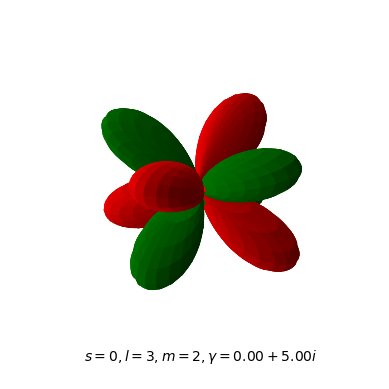

In [64]:
s, l, m, gamma = 0, 3, 2, 5j

r = np.real(spheroidal.harmonic(s,l,m,gamma)(theta,phi))
sign = np.sign(r)
r = abs(r)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
# Plot the surface
surface = ax.plot_surface(r * x, r * y, r * z, facecolors=cmap(norm(sign)), rstride=3, cstride=3,lightsource=ls)


# add text with parameters and time
text = ax.text2D(
    0.2,
    0.05,
    f"$s = {s}, l = {l}, m = {m}, \gamma = {np.real(gamma):.2f} + {np.imag(gamma):.2f}i$",
    #f"$s = {s}, l = {l}, m = {m}, \gamma = {abs(gamma):.1f}e^{{{abs(np.log(gamma/abs(gamma)))/np.pi:.2f}\pi i}}$",
    transform=ax.transAxes,
            )

ax.set_aspect("equal")
ax.axis('off')

plt.show()

In [40]:
from tqdm import tqdm
from matplotlib.animation import FuncAnimation
from matplotlib.animation import FFMpegWriter

num_frames = 360
fps = 30

g = lambda t: 10*np.sin(np.pi*t/6)**2*(1 if t<6 else 1j)
#g = lambda t: 5*np.exp(1j*np.pi*t/6)

# start progress bar
with tqdm(total=num_frames, ncols=80) as pbar:
    def draw_frame(i):
        pbar.update(1)

        ax.view_init(30, i)
        ax.set_aspect("equal")

        r = np.real(spheroidal.harmonic(s,l,m,g(i/fps))(theta,phi))
        sign = np.sign(r)
        r = abs(r)

        global surface
        surface.remove()
        surface = ax.plot_surface(r * x, r * y, r * z, facecolors=cmap(norm(sign)), rstride=3, cstride=3,lightsource=ls)

        text.set_text(f"$s = {s}, l = {l}, m = {m}, \gamma = {np.real(g(i/fps)):.2f} + {np.imag(g(i/fps)):.2f}i$")

    # save to file
    ani = FuncAnimation(fig, draw_frame, num_frames)
    FFwriter = FFMpegWriter(fps=fps)

    ani.save("spherical3.mp4", writer=FFwriter)
    # close figure so it doesn't show up in notebook
    plt.close(fig)

361it [10:47,  1.79s/it]                                                        


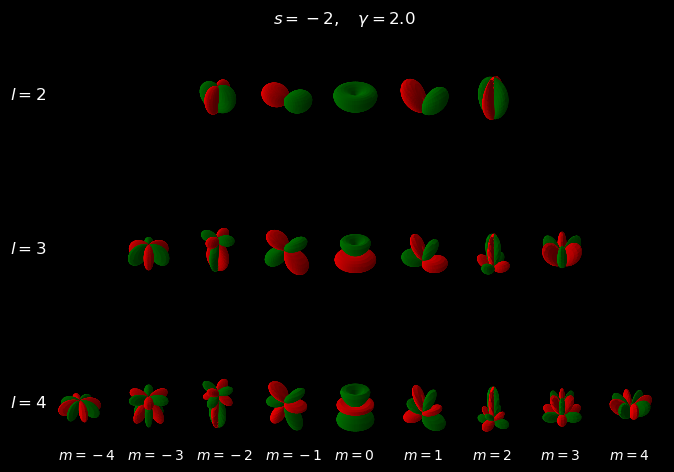

In [120]:
s = -2
gamma = 2.0
l_min = 2
l_max = 4

plt.style.use('dark_background')

fig, ax = plt.subplots(l_max-l_min+1, 2*l_max+1, subplot_kw=dict(projection='3d'), figsize=(8, 8))

l_vals = np.arange(l_min, l_max + 1)

for i,l in enumerate(l_vals):

    m_vals = np.arange(-l, l + 1)

    for j,m in enumerate(m_vals):
        r = np.real(spheroidal.harmonic(s,l,m,gamma,method="leaver")(theta,phi))
        sign = np.sign(r)
        r = abs(r)

        # Plot the surface
        ax[i,j+l_max-l].plot_surface(r * x, r * y, r * z, facecolors=cmap(norm(sign)), rstride=3, cstride=3,lightsource=ls)

        # add m labels to last row
        if l == l_vals[-1]:
            ax[i,j+l_max-l].text2D(
                0.2,
                -0.25,
                (f"$m = {m}$" if m >= 0 else f"$m=-{abs(m)}$"),
                transform=ax[i,j+l_max-l].transAxes,
                #size="large",
                        )
                        
# add l labels
for i,l in enumerate(l_vals):
    ax[i,0].text2D(
        -0.5,
        0.5,
        f"$l = {l}$",
        transform=ax[i,0].transAxes,
        size="large",
                )

fig.suptitle(f"$s = {s},\quad \gamma = {gamma}$",y=0.8)
            
for axes in ax.flatten():
    axes.axis('off')
    axes.set_aspect('equal')
    axes.set_facecolor('none')

fig.subplots_adjust(wspace=0, hspace=-0.5)

In [45]:
from tqdm import tqdm
from matplotlib.animation import FuncAnimation
from matplotlib.animation import FFMpegWriter

num_frames = 360
# start progress bar
with tqdm(total=num_frames, ncols=80) as pbar:
    def draw_frame(i):
        pbar.update(1)
        for axes in ax.flatten():
            axes.view_init(30, i)

    # save to file
    ani = FuncAnimation(fig, draw_frame, num_frames)
    FFwriter = FFMpegWriter(fps=30)

    ani.save("spherical_full.mp4", writer=FFwriter)
    # close figure so it doesn't show up in notebook
    plt.close(fig)


361it [18:44,  3.12s/it]                                                        
